In [65]:
%load_ext autoreload
%autoreload 2

from src.experiments.common import Experiment
from src.visualization.grad_variance_estimates import *
import matplotlib.pyplot as plt
import pandas as pd
from hydra.utils import instantiate
import seaborn as sns
from src.visualization.simulated import *
experiment = Experiment("sghmc_stats")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
m_run = experiment.latest_run()

def eval_poly(x, coeffs):
    return coeffs[0] + sum(c*x**i for i, c in enumerate(coeffs[1:], start=1))

dataset = instantiate(m_run.runs[0].config.data.dataset)
X, Y = dataset[:]

In [67]:
posterior = get_exact_posterior(X, Y)
sample_data = pd.concat(
    load_samples(r)
    .reset_index(level=["sampler", "batch_size"], drop=True)
    .assign(
        variance_estimator=r.config["inference"]["sampler"]["variance_estimator"][
            "_target_"
        ]
    )
    .assign(
        variance_estimator=lambda x: x.variance_estimator.str.extract(
            "src.inference.mcmc.variance_estimators.(.+)"
        )
    )
    .set_index("variance_estimator", append=True)
    .reorder_levels(["variance_estimator", "sample"])
    for r in m_run.runs
    if "sampler" in r.config["inference"]
)

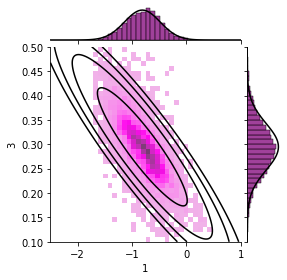

In [68]:
i = 1
j = 3
joint_plots = {}

xlims = (-2.5, 1.0)
ylims = (0.1, 0.5)

with (sns.color_palette(PLOT_COLORS[("SGHMCWithVarianceEstimator", 5)]["color_palette"])):
    plot_sampled_joint_bivariate(
        sample_data.loc["ConstantEstimator"][[i, j]],
        exact_posterior=posterior,
        xlims=xlims,
        ylims=ylims,
    )
    plt.savefig("simulated_joint_SGHMCWithVarianceEstimator_5.pdf")


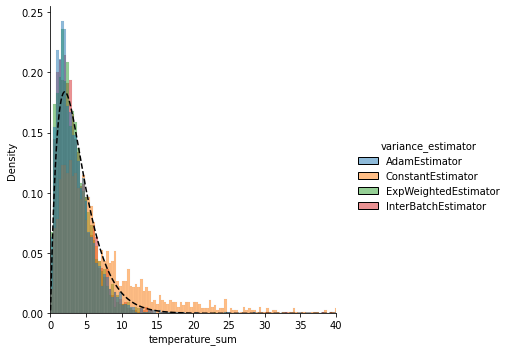

In [62]:
import re
def assign_var_estimator(data, run):

    estimator = run.config["inference"]["sampler"]["variance_estimator"]["_target_"]
    estimator = re.match("src.inference.mcmc.variance_estimators.(.+)", estimator)[1]
    return data.assign(variance_estimator = estimator)

def get_temperature_samples(run):
    samples = torch.load(run.path / "temperature_samples.pt")
    return (
        pd.DataFrame.from_dict(samples, orient="index")
        .unstack(1)
        .reorder_levels((1, 0), axis=1)
        .rename_axis(index="step", columns=["parameter", "value"])
    )

temperature_samples = pd.concat(
        get_temperature_samples(run)
        .pipe(assign_var_estimator, run=run)
        .set_index("variance_estimator", append=True)
        .reorder_levels([1, 0])
        for run in m_run.runs
    )

(
    temperature_samples
    .loc[:, "linear.weight"]
    .reset_index()
    .pipe(
        (sns.displot, "data"),
        x="temperature_sum",
        hue="variance_estimator",
        kind="hist",
        stat="density",
        common_norm=False
    )
)
plt.xlim(0, 40)
xx = np.linspace(0.01, 40, 300)
plt.plot(
    xx, torch.distributions.Chi2(4).log_prob(xx).exp(), color="black", linestyle="--"
)


In [63]:
temperature_samples

parameter                   linear.weight         
value                     temperature_sum n_params
variance_estimator  step                          
AdamEstimator       0           12.595733        4
                    45          71.095825        4
                    90         140.934204        4
                    135         50.274200        4
                    180          9.039961        4
...                                   ...      ...
InterBatchEstimator 89775        0.478304        4
                    89820        2.394891        4
                    89865        1.736064        4
                    89910        3.369559        4
                    89955        6.264155        4

[8000 rows x 2 columns]

In [64]:
from scipy.stats import chi2

def compute_99_chi2(x):
    df = x.index.get_level_values("n_params")[0]
    return (x < chi2(df).ppf(0.99)).mean()

(
    temperature_samples.stack(level="parameter")
    .set_index("n_params", append=True)
    .groupby(level=["variance_estimator", "parameter"])
    .agg(
        frac_in_99=pd.NamedAgg(
            "temperature_sum", aggfunc=compute_99_chi2
        )
    )
    .unstack("parameter")
)


,frac_in_99
parameter,linear.weight
variance_estimator,
AdamEstimator,0.9870
ConstantEstimator,0.8545
ExpWeightedEstimator,0.9945
InterBatchEstimator,0.9880
